In [10]:
# Cell 1: Imports & basic settings

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

import joblib

RANDOM_STATE = 42

print("Current working dir:", os.getcwd())


Current working dir: c:\Users\PC\Desktop\2025ML-spamEmail\notebooks


In [11]:
# Cell 2: Load TF-IDF split, best model, and vectorizer

# 這些路徑跟 01 / 02 那邊保持一致
tfidf_split_path = "../models/train_test_tfidf.pkl"
best_model_path = "../models/best_model.pkl"
vectorizer_path = "../models/tfidf_vectorizer.pkl"

X_train_tfidf, X_test_tfidf, y_train, y_test = joblib.load(tfidf_split_path)
best_model = joblib.load(best_model_path)
tfidf_vectorizer = joblib.load(vectorizer_path)

print(">>> Loaded:")
print(" - TF-IDF split from:", tfidf_split_path)
print(" - Best model from  :", best_model_path)
print(" - Vectorizer from  :", vectorizer_path)

print("\nX_test_tfidf shape:", X_test_tfidf.shape)
print("y_test length      :", len(y_test))

print("\nBest model:", best_model)


>>> Loaded:
 - TF-IDF split from: ../models/train_test_tfidf.pkl
 - Best model from  : ../models/best_model.pkl
 - Vectorizer from  : ../models/tfidf_vectorizer.pkl

X_test_tfidf shape: (1115, 12076)
y_test length      : 1115

Best model: LinearSVC(random_state=42)


>>> Confusion matrix (raw):
[[963   3]
 [ 12 137]]

Labels order: ['ham', 'spam']


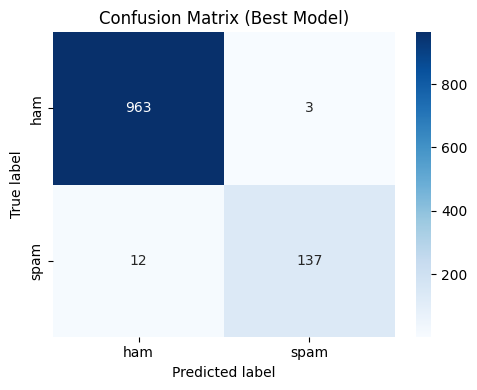

In [12]:
# Cell 3: Confusion matrix (heatmap)

# 使用 best_model 在測試集上預測
y_pred = best_model.predict(X_test_tfidf)

labels_sorted = sorted(list(set(y_test)))  # 例如 ['ham', 'spam'] 或 [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

print(">>> Confusion matrix (raw):")
print(cm)
print("\nLabels order:", labels_sorted)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Best Model)")
plt.tight_layout()
plt.show()


In [13]:
# Cell 4: Classification report (table)

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).T  # 每一列是 class / macro avg / weighted avg

print(">>> Classification report (dict form):")
display(report_df)

# 如果你想要四捨五入好看一點：
report_df_rounded = report_df.copy()
for col in ["precision", "recall", "f1-score", "support"]:
    if col in report_df_rounded.columns:
        if col != "support":
            report_df_rounded[col] = report_df_rounded[col].apply(lambda x: round(x, 4))
display(report_df_rounded)


>>> Classification report (dict form):


,precision,recall,f1-score,support
ham,0.987692,0.996894,0.992272,966.000000
spam,0.978571,0.919463,0.948097,149.000000
accuracy,0.986547,0.986547,0.986547,0.986547
macro avg,0.983132,0.958179,0.970184,1115.000000
weighted avg,0.986473,0.986547,0.986369,1115.000000


,precision,recall,f1-score,support
ham,0.9877,0.9969,0.9923,966.000000
spam,0.9786,0.9195,0.9481,149.000000
accuracy,0.9865,0.9865,0.9865,0.986547
macro avg,0.9831,0.9582,0.9702,1115.000000
weighted avg,0.9865,0.9865,0.9864,1115.000000


>>> Using decision_function for ROC curve.


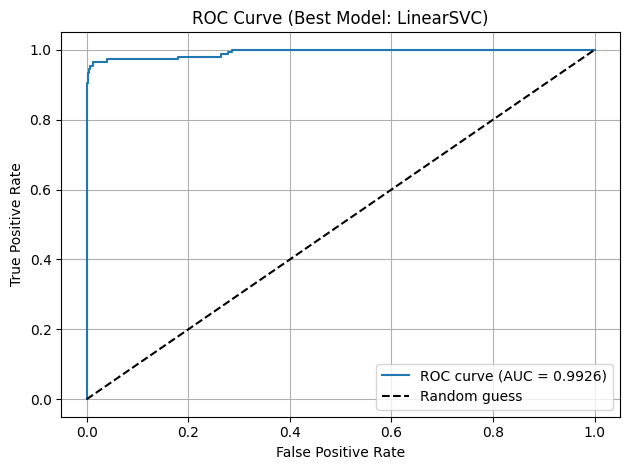

In [14]:
# Cell 5: ROC curve (if supported by the model)

# 把 y_test 轉成二元 0/1，假設 'spam' 是 positive class
# 如果你的正類不是 'spam'，請改這裡
positive_label = "spam"

y_true_binary = np.array([1 if y == positive_label else 0 for y in y_test])

y_scores = None

if hasattr(best_model, "predict_proba"):
    # 例如 Logistic Regression / Naive Bayes
    proba = best_model.predict_proba(X_test_tfidf)
    # 找出 positive label 在 classes_ 中的 index
    classes = list(best_model.classes_)
    pos_index = classes.index(positive_label)
    y_scores = proba[:, pos_index]
    print(">>> Using predict_proba for ROC curve.")
elif hasattr(best_model, "decision_function"):
    # 例如 LinearSVC
    y_scores = best_model.decision_function(X_test_tfidf)
    print(">>> Using decision_function for ROC curve.")
else:
    print(">>> This model does not support predict_proba or decision_function. Skipping ROC curve.")

if y_scores is not None:
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (Best Model: {type(best_model).__name__})")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


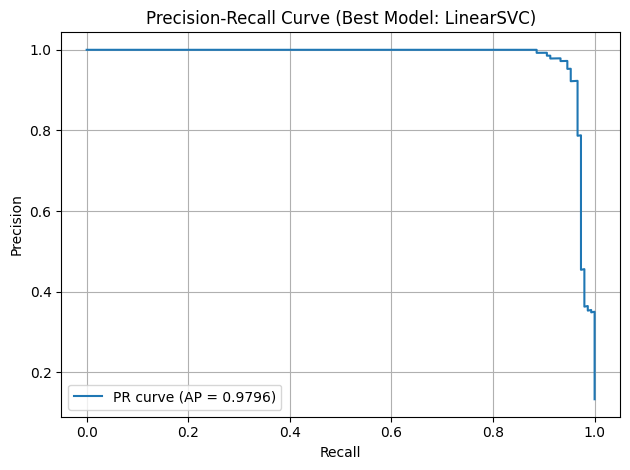

In [15]:
# Cell 6: Precision-Recall curve (if scores available)

if y_scores is not None:
    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_scores)
    ap = average_precision_score(y_true_binary, y_scores)
    
    plt.figure()
    plt.plot(recall, precision, label=f"PR curve (AP = {ap:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve (Best Model: {type(best_model).__name__})")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(">>> No score available, skipping Precision-Recall curve.")


Model classes_: ['ham', 'spam']
>>> Top spam-related features:


,feature,weight
19,txt,2.317460
18,call,1.878724
17,text,1.763542
16,uk,1.709567
15,reply,1.623225
14,mobile,1.580463
13,claim,1.535480
12,www,1.482957
11,150p,1.469620
10,ringtone,1.325742


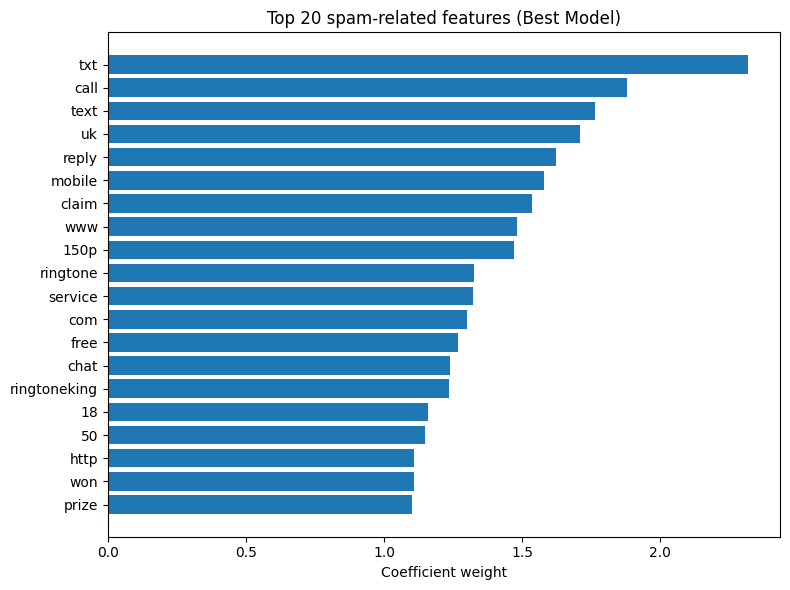

In [16]:
# Cell 7: Top spam words / feature importance (if model has coef_)

if hasattr(best_model, "coef_"):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    classes = list(best_model.classes_)
    print("Model classes_:", classes)
    
    if positive_label in classes:
        # 對於二元分類：
        # - classes_ 有 2 個類別，例如 ['ham', 'spam']
        # - coef_.shape == (1, n_features)
        #   -> 這一列代表 classes_[1]（第二個類別）相對於 classes_[0] 的方向
        #   -> 如果 positive_label == classes_[1]，直接用 coef_[0]
        #   -> 如果 positive_label == classes_[0]，就把 coef_[0] 乘以 -1
        coef = best_model.coef_
        if coef.shape[0] == 1:
            # binary case
            spam_coef = coef[0].copy()
            if positive_label == classes[0]:
                # 如果你選的正類其實是 classes_[0]，權重要反向
                spam_coef = -spam_coef
        else:
            # 多類別情況（這作業基本不會用到，但還是寫好）
            spam_index = classes.index(positive_label)
            spam_coef = coef[spam_index]

        # 取權重最高的前 20 個特徵
        top_n = 20
        top_indices = np.argsort(spam_coef)[-top_n:]
        top_features = feature_names[top_indices]
        top_weights = spam_coef[top_indices]

        # 做成 DataFrame 好看
        importance_df = pd.DataFrame({
            "feature": top_features,
            "weight": top_weights
        }).sort_values(by="weight", ascending=True)  # 從小到大畫，barh 比較好看

        print(">>> Top spam-related features:")
        display(importance_df.sort_values(by="weight", ascending=False))

        plt.figure(figsize=(8, 6))
        plt.barh(importance_df["feature"], importance_df["weight"])
        plt.xlabel("Coefficient weight")
        plt.title(f"Top {top_n} spam-related features (Best Model)")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Positive label '{positive_label}' not found in model.classes_. Cannot compute spam-specific features.")
else:
    print(">>> This best model does not have coef_, skipping feature importance plot.")
